### mini_project_bike_rent

In [410]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### 1. Загрузка данных, проверка числа наблюдений и столбцов, типов данных, наличия пропущенных значений, уникальных значений

In [411]:
# Чтение файла, предварительный просмотр датасета
london = pd.read_csv('london.csv')
london.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [412]:
# Просмотр количества наблюдений и столбцов в датасете
print("{0} строки, {1} столбцов".format(london.shape[0], london.shape[1]))

17414 строки, 10 столбцов


In [449]:
london.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [413]:
# Проверка наличия пропущенных значений
london.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [414]:
# Проверка типов данных в датасете
london.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [415]:
# Преобразование типа данных в столбце timestamp         
london.timestamp = pd.to_datetime(london.timestamp, dayfirst=True)

#### 2. Просмотр числа поездок по датам и времени

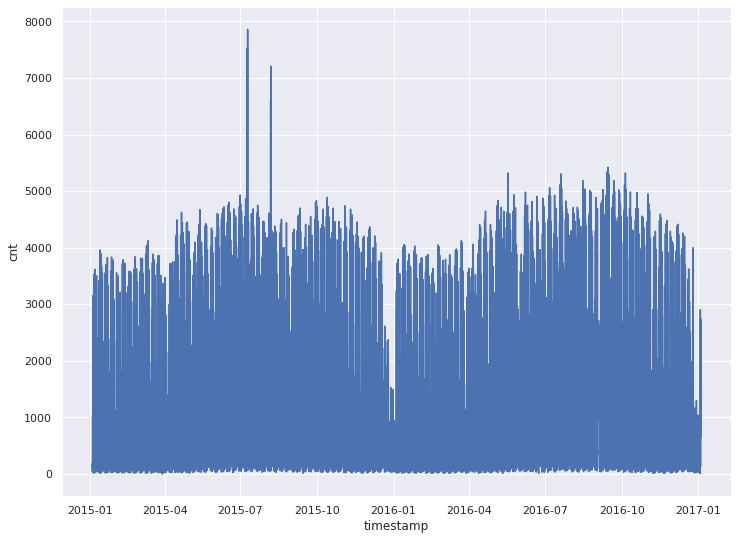

In [416]:
plt.figure(figsize=(12,9))
sns.lineplot(data=london, x='timestamp', y='cnt')
# Такая визуализация не позволяет делать точные выводы, необходимо преобразование данных

#### 3. Преобразование данных

In [417]:
london = london.sort_values('timestamp').set_index('timestamp')

In [418]:
day_cnt = london.resample('D', 'index').sum().cnt.to_frame()
day_cnt.head()

,cnt
timestamp,
2015-01-04,9234
2015-01-05,20372
2015-01-06,20613
2015-01-07,21064
2015-01-08,15601


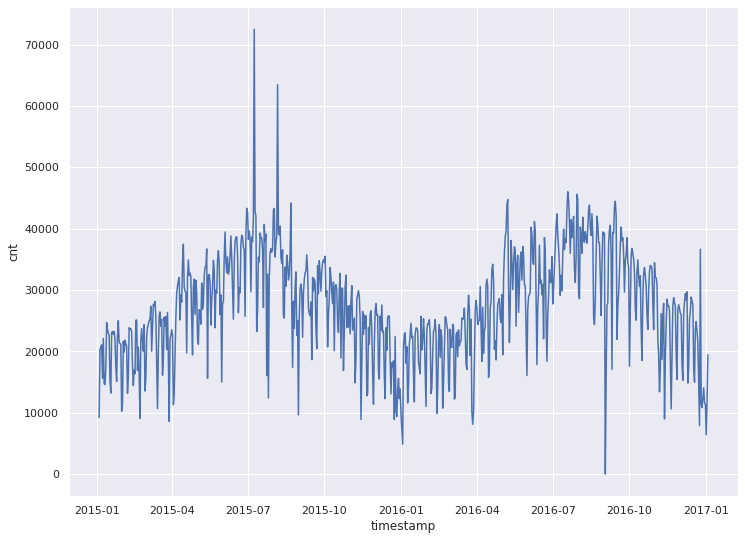

In [419]:
plt.figure(figsize=(12,9))
sns.lineplot(data=day_cnt, x='timestamp', y='cnt')

##### Полученный график позволяется отметить, что встречаются резкие скачки вверх и вниз, максимальное число аренд в день превышает 70000, а зимой число аренд меньше, чем летом.

#### 4. Изучение резких взлетов и падений графика

In [420]:
# Подсчёт скользящего среднего для сглаживания ряда
window_size = 3
day_rolling = day_cnt.rolling(window_size).mean().reset_index().rename(columns={'cnt':'rolling'})

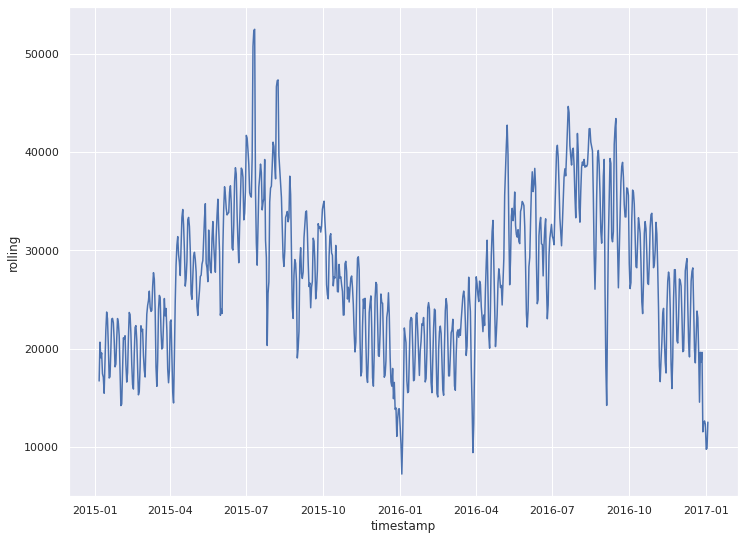

In [421]:
plt.figure(figsize=(12,9))
sns.lineplot(data=day_rolling, x='timestamp', y='rolling')

In [422]:
# Поиск значения для даты 2015-07-09
day_cnt.iloc[186]

cnt    72504
Name: 2015-07-09 00:00:00, dtype: int64

In [423]:
# Подсчёт стандартного отклонения
day_cnt = day_cnt.reset_index().merge(day_rolling, on='timestamp')

In [424]:
day_cnt = day_cnt.assign(diff = day_cnt['cnt'] - day_cnt['rolling'])

In [425]:
std = np.std(day_cnt['diff'])

In [426]:
print('Стандартное отклонение равно ', std, sep='')

Стандартное отклонение равно 4558.58664111794


Определение доверительного интервала

In [427]:
day_cnt = day_cnt.assign(lower_bound = day_cnt['rolling'] - 2.576 * std)
day_cnt = day_cnt.assign(upper_bound = day_cnt['rolling'] + 2.576 * std)

In [428]:
day_cnt.head()

,timestamp,cnt,rolling,diff,lower_bound,upper_bound
0,2015-01-04,9234,NaN,NaN,NaN,NaN
1,2015-01-05,20372,NaN,NaN,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333,4996.747479,28482.585854
3,2015-01-07,21064,20683.000000,381.000000,8940.080812,32425.919188
4,2015-01-08,15601,19092.666667,-3491.666667,7349.747479,30835.585854


In [436]:
# Вывод значений, которые оказались выше верхней границы доверительного интервала - аномалий
day_cnt.query('cnt > upper_bound').sort_values('cnt')

,timestamp,cnt,rolling,diff,lower_bound,upper_bound
609,2016-09-04,27512,14259.000000,13253.000000,2516.080812,26001.919188
721,2016-12-25,36653,19650.666667,17002.333333,7907.747479,31393.585854
214,2015-08-06,63468,46627.333333,16840.666667,34884.414146,58370.252521
186,2015-07-09,72504,50705.000000,21799.000000,38962.080812,62447.919188


In [459]:
# Вывод значений, которые оказались меньше нижней границы доверительного интервала - аномалий
day_cnt.query('cnt < lower_bound').sort_values('cnt')

,timestamp,cnt,rolling,diff,lower_bound,upper_bound
607,2016-09-02,0,26086.333333,-26086.333333,14343.414146,37829.252521
314,2015-11-14,8898,21037.333333,-12139.333333,9294.414146,32780.252521
678,2016-11-12,8990,20878.000000,-11888.000000,9135.080812,32620.919188
130,2015-05-14,15609,28709.333333,-13100.333333,16966.414146,40452.252521
201,2015-07-24,16034,31013.666667,-14979.666667,19270.747479,42756.585854
615,2016-09-10,17080,31262.000000,-14182.000000,19519.080812,43004.919188
232,2015-08-24,17400,29529.333333,-12129.333333,17786.414146,41272.252521
621,2016-09-16,21967,36193.333333,-14226.333333,24450.414146,47936.252521
189,2015-07-12,23240,36036.666667,-12796.666667,24293.747479,47779.585854


#### 5. Анализ аномалий в таблице

In [430]:
london = london.reset_index()

In [433]:
london['timestamp'] = pd.to_datetime(london.timestamp).dt.strftime('%Y-%m-%d')

В данных корректно отображаются значения времени года, выходных и праздничных дней. Отсутствуют дублирующие строки.

In [457]:
london.query('timestamp in ("2016-09-04", "2016-12-25", "2015-08-06", "2015-07-09")').head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
4453,2015-07-09,400,16.0,16.0,55.0,14.0,1.0,0.0,0.0,1.0
4454,2015-07-09,212,15.5,15.5,59.0,14.0,1.0,0.0,0.0,1.0
4455,2015-07-09,111,14.0,14.0,67.0,15.0,1.0,0.0,0.0,1.0
4456,2015-07-09,81,14.0,14.0,63.0,18.5,1.0,0.0,0.0,1.0
4457,2015-07-09,76,14.0,14.0,63.0,18.0,1.0,0.0,0.0,1.0


Из следующего запроса видно, что погодные условия в каждую дату были относительно комфортными для поездок на велосипеде. Можно предположить, что ошибок в сборе данных нет. Возможно, причина увеличения спроса на аренду велосипеда заключается в сложившейся в городе ситуации, располагающей к предпочтению велосипедов другим транспортным средствам. Например, пробки на дорогах или закрытое по какой-либо причине метро, учитывая что 2 дня из 4-х аномальных являются будними днями. 
Рассуждения подтверждают данные ria.ru (https://ria.ru/20150709/1123507295.html , https://ria.ru/20160904/1476048660.html), согласно которым, 2015-07-09 и 2016-09-04 были забастовки в метро.

In [453]:
london.query('timestamp in ("2016-09-04", "2016-12-25", "2015-08-06", "2015-07-09")') \
      .groupby('timestamp', as_index=False) \
      .agg({'cnt':'sum', 't1':'mean', 'wind_speed':'mean'}) \
      .rename(columns={'sum':'cnt_sum', 't1':'t1_mean', 'wind_speed':'wind_speed_mean'})

,timestamp,cnt,t1_mean,wind_speed_mean
0,2015-07-09,72504,17.791667,12.979167
1,2015-08-06,63468,19.437500,14.895833
2,2016-09-04,27512,18.854167,23.395833
3,2016-12-25,36653,12.500000,27.666667
